In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import numpy as np
from scipy import io
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from utils import model_selection
from collections import defaultdict
from sklearn.metrics import mutual_info_score, accuracy_score
from tqdm import tqdm
from itertools import product
import pandas as pd

sns.set_style('ticks')
sns.set_context('notebook',font_scale=1.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
dat = io.loadmat('/data/neurons08.mat')
ori, contrasts, n_bins, n_trials, times = \
    dat['ori'].squeeze(),  dat['contrast'].squeeze(), int(dat['nBins']), int(dat['nTrials']), dat['times'].squeeze()
responses = np.stack([np.stack(e[:-1], axis=0)  for e in dat['feat'].squeeze()], axis=0) # :-1 to exclude last incomplete trials
print('contrast X orientations X neurons X time X trials', responses.shape)


contrast X orientations X neurons X time X trials (2, 7, 20, 90, 85)


### a) compute mutual information

In [68]:
orientation_classes = [0,4]
results = defaultdict(list)
params = dict(
            C=10.**np.arange(-5.,1.5, .5), 
            penalty=['l1','l2']
        )

for (i_contrast, contrast), (i_time, t) in tqdm(product(enumerate(contrasts), enumerate(times))):
    X = np.vstack([responses[i_contrast, _, :, i_time, :].T for _ in orientation_classes])
    y = np.ones(2*n_trials)
    y[n_trials:] = 2
    for resample, (train_idx, test_idx) in enumerate(StratifiedShuffleSplit(y, n_iter=5, test_size=.3)):
        model = LogisticRegression(C=1.,penalty='l2')
        
        best = model_selection(model, X[train_idx], y[train_idx], params, cv=5,  scoring='accuracy', n_jobs=5)
        yhat = best.predict(X[test_idx])
        results['time [ms]'].append(t)
        results['contrast'].append(contrast)
        results['accuracy'].append(accuracy_score(y[test_idx], yhat))
        results['resample'].append(resample)
        results['mutual information [bits]'].append(mutual_info_score(y[test_idx], yhat)/np.log(2.))
        
        
        

180it [05:16,  1.85s/it]


### b) plot the time course

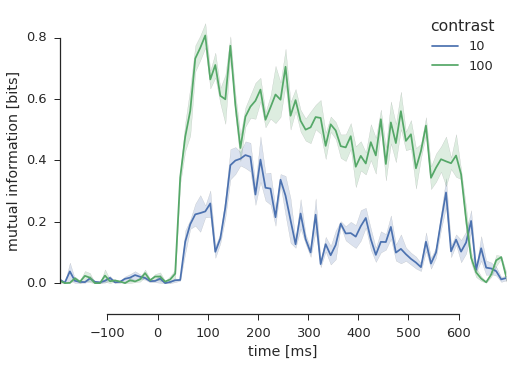

In [71]:
df = pd.DataFrame(results)
g = sns.tsplot(df, time='time [ms]', unit='resample', condition='contrast', value='mutual information [bits]')
sns.despine(trim=True)